In [1]:
from typing import Dict
from cfgnet.network.network_configuration import NetworkConfiguration
from cfgnet.network.nodes import ArtifactNode
from cfgnet.network.network import Network
from pprint import pprint
from tqdm import tqdm
import git
import json
import traceback


def analyze_config_network(repo_path: str):
    
    network_config = NetworkConfiguration(
        project_root_abs=repo_path,
        enable_static_blacklist=False,
        enable_internal_links=True,
        enable_all_conflicts=True,
        enable_file_type_plugins=True,
        system_level=False
    )

    network = Network.init_network(cfg=network_config)

    artifacts = network.get_nodes(node_type=ArtifactNode)

    config_files_data = []
    for artifact in artifacts:
        config_files_data.append({
            "file_path": artifact.rel_file_path,
            "options": len(artifact.get_pairs())
        })


    config_files = set(artifact.rel_file_path for artifact in artifacts)
    concepts = set(artifact.concept_name for artifact in artifacts)
  	
    network_data = {
        "links": len(network.links),
        "concepts": list(concepts),
        "config_files": list(config_files),
        "config_files_data": config_files_data
    }

    return network_data


def analyze_repository(repo_path: str, branch_name: str = "main") -> Dict:
    """Analyze Commit history of repositories and collect stats about the configuration space."""   
    
    project_name = repo_path.split("/")[-1]

    repo = git.Repo(repo_path)

    # Save the current branch to return to it later
    current_branch = repo.active_branch.name if not repo.head.is_detached else None
    latest_commit = repo.head.commit.hexsha

    # Get all commits in the repository from oldest to newest
    commits = list(repo.iter_commits(branch_name))[::-1] 

    print(f"Number of commits: {len(commits)}")

    commit_data = []

    for commit in tqdm(commits, desc="Processing", total=len(commits)):

        # get commit stats
        stats = commit.stats.total

        # Checkout the commit
        repo.git.checkout(commit.hexsha)

        # Run the external analysis (replace with your actual command)
        try: 
            network_data = analyze_config_network(repo_path=repo_path)
        except Exception:
            print(f"Error occurred in commit {commit.hexsha}")
            print({traceback.print_exc()})
            return


        # Get general stats per file
        for file_path, file_stats in commit.stats.files.items():

            if file_path in network_data["config_files"]:

                file_data = next(filter(lambda x: x["file_path"] == file_path, network_data["config_files_data"]))
                file_data["insertions"] = file_stats['insertions']
                file_data["deletions"] = file_stats['deletions']
                file_data["total_changes"] = file_stats['insertions'] + file_stats['deletions']

            # Only proceed if the commit has a parent (to avoid errors on the first commit)
            #if commit.parents:
            #    parent_commit = f"{commit.hexsha}^"

                #try:
                    # Run git diff to capture line-by-line changes
                    #diff_output = subprocess.check_output(
                    #    ['git', 'diff', parent_commit, commit.hexsha, '--', file_path],
                    #    cwd=repo_path,
                    #    text=True
                    #)
                    #print("  Diff Output:\n", diff_output)

                    # Capture file size before and after the commit
                    #file_content_after = repo.git.show(f"{commit.hexsha}:{file_path}")
                    #size_after = len(file_content_after.encode('utf-8'))

                    #file_content_before = repo.git.show(f"{parent_commit}:{file_path}")
                    #size_before = len(file_content_before.encode('utf-8'))

                    #print(f"  Size Before: {size_before} bytes")
                    #print(f"  Size After: {size_after} bytes")
                    #print(f"  Net Size Change: {size_after - size_before} bytes")
                
                #except subprocess.CalledProcessError as e:
                    #print(f"  Error running git diff: {e}")
                #except git.exc.GitCommandError:
                    #print("  File did not exist in previous commit (added in this commit)")

            #else:
                #print("  No parent commit available (this is the first commit)")

        commit_data.append(
            {
                "commit_hash": str(commit.hexsha),
                "author": f"{commit.author.name} <{commit.author.email}>",
                "commit_mgs": str(commit.message),
                "files_changed": stats['files'],
                "insertions": stats['insertions'],
                "deletions": stats['deletions'],
                "network_data": network_data
            }
        )

    # Finally, return to the latest commit
    if current_branch:
        # If we were on a branch, return to it
        repo.git.checkout(current_branch)
        print(f"Returned to original branch: {current_branch}")
    else:
        # If we were in a detached HEAD state, checkout the latest commit directly
        repo.git.checkout(latest_commit)
        print(f"Returned to the latest commit: {latest_commit}")

    output_file = f"../data/analyzed_projects/{project_name}.json"

    with open(output_file, "w", encoding="utf-8") as dest:
        json.dump(commit_data, dest, indent=2)

test_repo_path = "/home/ssimon/github/projects/netflix-oss-example"

analyze_repository(repo_path=test_repo_path, branch_name="master")

Number of commits: 121


Processing:  97%|█████████▋| 117/121 [00:05<00:00, 16.49it/s]WARNING:root:Failed to parse yml file "spring-cloud-dashboard/src/main/resources/application.yml"" with spring parser due to "expected a single document in the stream
  in "/home/ssimon/github/projects/netflix-oss-example/spring-cloud-dashboard/src/main/resources/application.yml", line 1, column 1
but found another document
  in "/home/ssimon/github/projects/netflix-oss-example/spring-cloud-dashboard/src/main/resources/application.yml", line 9, column 1"
Processing:  98%|█████████▊| 119/121 [00:05<00:00, 15.47it/s]WARNING:root:Failed to parse yml file "spring-cloud-dashboard/src/main/resources/application.yml"" with spring parser due to "expected a single document in the stream
  in "/home/ssimon/github/projects/netflix-oss-example/spring-cloud-dashboard/src/main/resources/application.yml", line 1, column 1
but found another document
  in "/home/ssimon/github/projects/netflix-oss-example/spring-cloud-dashboard/src/main/resour

Returned to original branch: master


**Evolution of configuration files**

- shows the growth of each file
- might be usefull to group files by concepts

/tmp/ipykernel_216567/1467293423.py:53: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


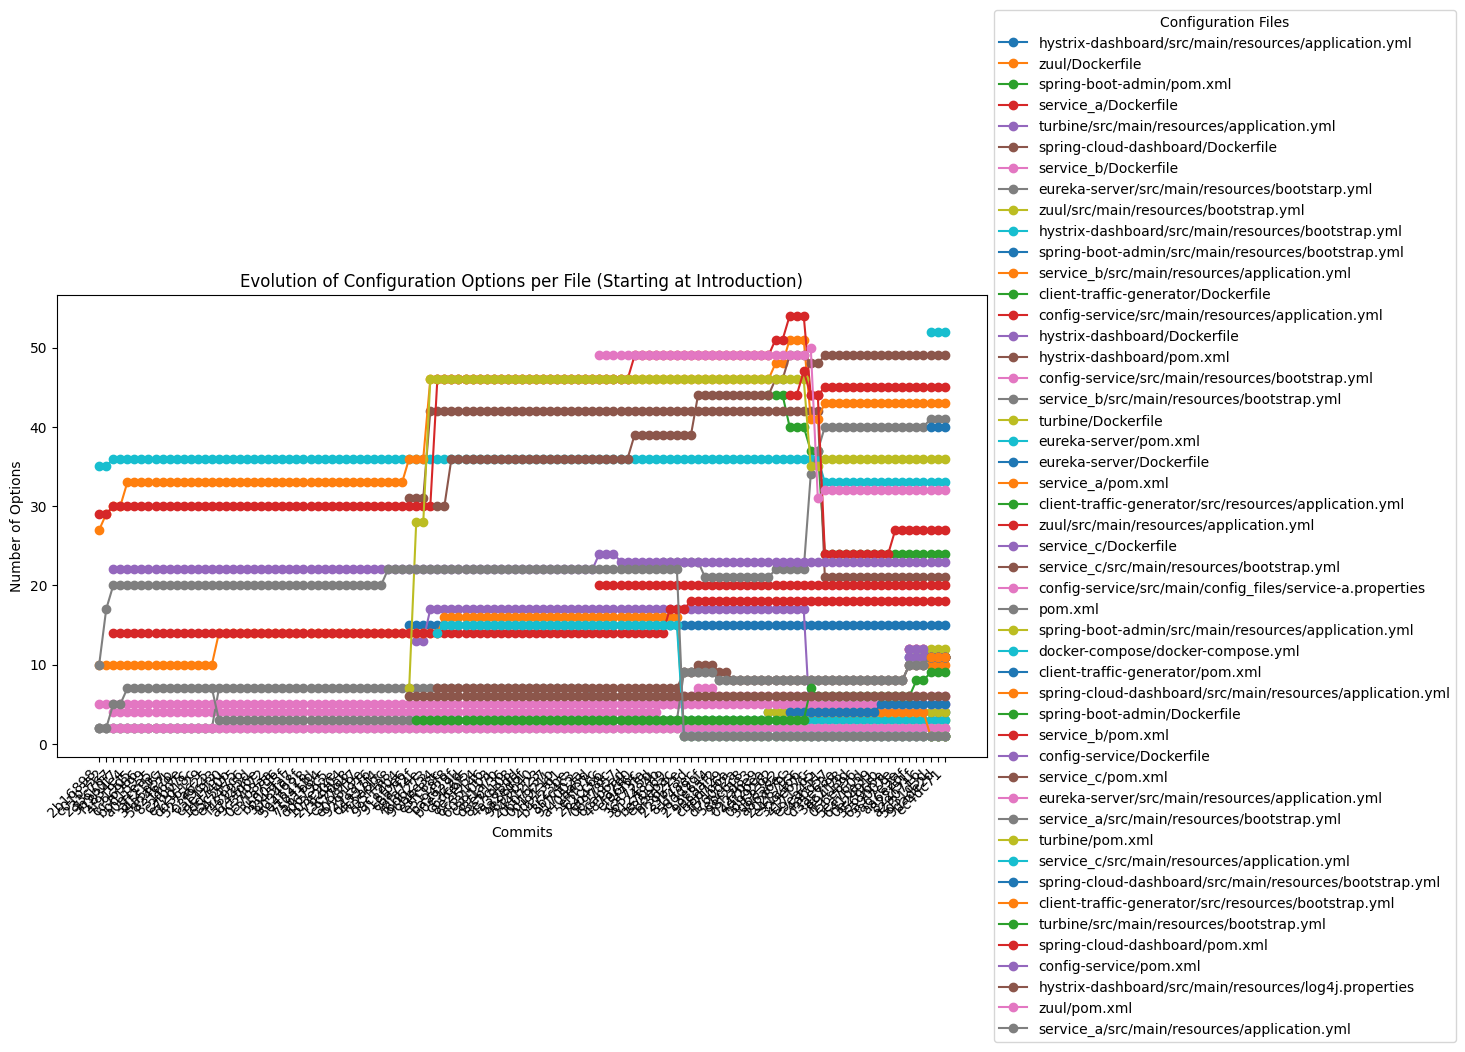

In [2]:
import matplotlib.pyplot as plt
import json

with open("../data/analyzed_projects/netflix-oss-example.json", "r", encoding="utf-8") as src:
    data = json.load(src)

# Extract data for plotting
files = set()
file_data = {}

for commit in data:
    commit_hash = commit["commit_hash"]
    for config_file in commit["network_data"]["config_files_data"]:
        file_path = config_file["file_path"]
        options = config_file["options"]
        files.add(file_path)
        if file_path not in file_data:
            file_data[file_path] = []
        file_data[file_path].append((commit_hash, options))

# Prepare data for plotting
x_ticks = [commit["commit_hash"] for commit in data]

# Adjust the plotting logic to start the line at the introduction commit
file_lines = {file: [None] * len(x_ticks) for file in files}

for file, changes in file_data.items():
    for commit_hash, options in changes:
        index = x_ticks.index(commit_hash)
        file_lines[file][index] = options

# Replace None with previous values for continuity
for file, options in file_lines.items():
    last_value = None
    for i in range(len(options)):
        if options[i] is None:
            options[i] = last_value
        else:
            last_value = options[i]

shortened_x_ticks = [commit[:7] for commit in x_ticks]

# Re-plot with shortened commit hashes
plt.figure(figsize=(12, 6))
for file, options in file_lines.items():
    plt.plot(shortened_x_ticks, options, marker="o", label=file)

plt.xlabel("Commits")
plt.ylabel("Number of Options")
plt.title("Evolution of Configuration Options per File (Starting at Introduction)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Configuration Files", loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

**Evolution of the configuration space in software project**

- shows the total number of configuration options over time

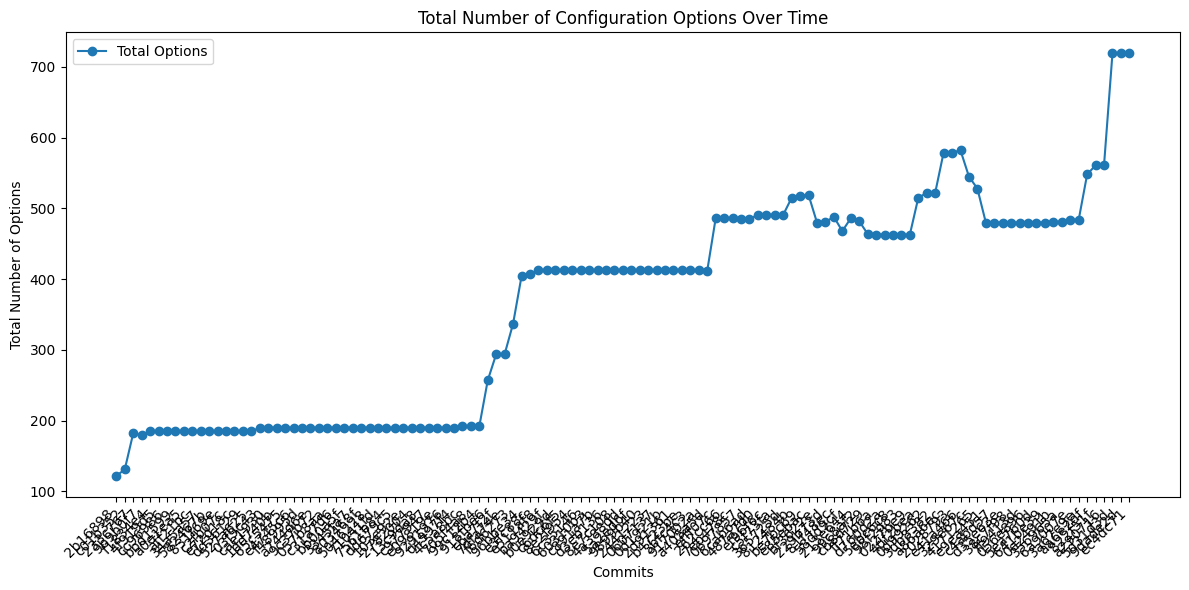

In [3]:
import matplotlib.pyplot as plt

# Extract data for plotting
files = set()
file_data = {}

for commit in data:
    commit_hash = commit["commit_hash"]
    for config_file in commit["network_data"]["config_files_data"]:
        file_path = config_file["file_path"]
        options = config_file["options"]
        files.add(file_path)
        if file_path not in file_data:
            file_data[file_path] = []
        file_data[file_path].append((commit_hash, options))

# Prepare data for plotting
x_ticks = [commit["commit_hash"] for commit in data]

# Adjust the plotting logic to start the line at the introduction commit
file_lines = {file: [None] * len(x_ticks) for file in files}

for file, changes in file_data.items():
    for commit_hash, options in changes:
        index = x_ticks.index(commit_hash)
        file_lines[file][index] = options

# Calculate the total number of options across all configuration files per commit
total_options_per_commit = [0] * len(x_ticks)

for file, options in file_lines.items():
    for i, option_count in enumerate(options):
        if option_count is not None:
            total_options_per_commit[i] += option_count

# Plot the total number of options over time
plt.figure(figsize=(12, 6))
plt.plot(shortened_x_ticks, total_options_per_commit, marker="o", label="Total Options")

plt.xlabel("Commits")
plt.ylabel("Total Number of Options")
plt.title("Total Number of Configuration Options Over Time")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

**Distribution of config-related and non-config-related commits**

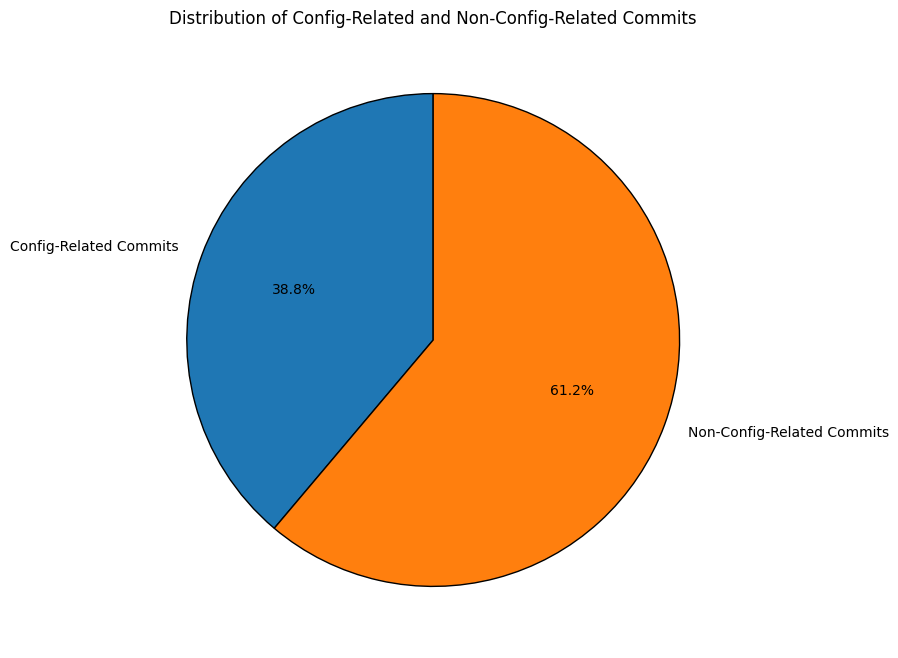

In [4]:
import matplotlib.pyplot as plt

config_related_count = 0
non_config_related_count = 0

for commit in data:
    config_files_changed = any(
        "insertions" in file or "deletions" in file
        for file in commit["network_data"]["config_files_data"]
    )
    if config_files_changed:
        config_related_count += 1
    else:
        non_config_related_count += 1

# Data for the pie chart
labels = ['Config-Related Commits', 'Non-Config-Related Commits']
sizes = [config_related_count, non_config_related_count]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={'linewidth': 1, 'edgecolor': 'black'})
plt.title("Distribution of Config-Related and Non-Config-Related Commits")
plt.show()

**Illstrate the frequency how often a specific config file has changed**

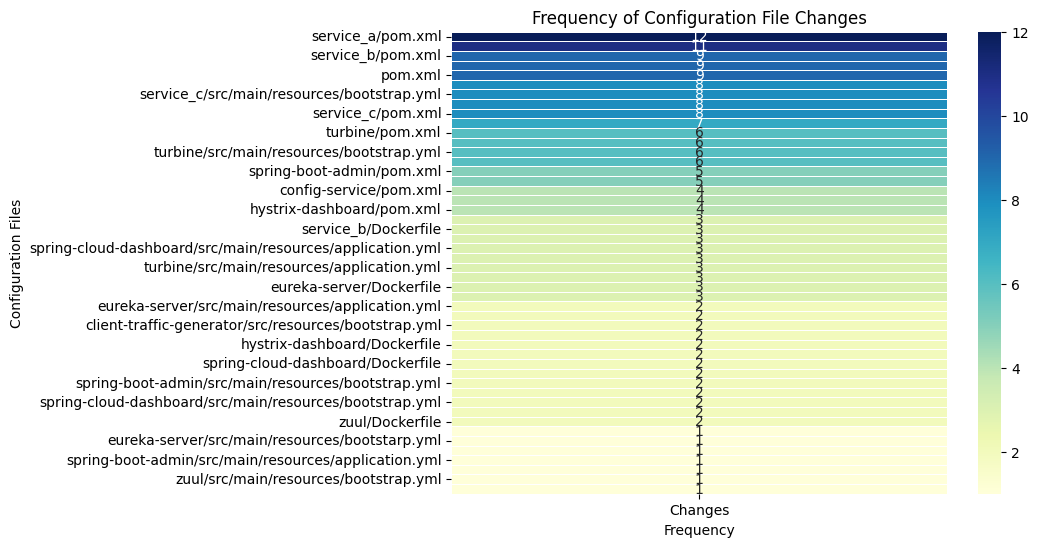

In [5]:
import seaborn as sns
import pandas as pd

# Count how often each configuration file has changed
file_change_counts = {}

for commit in data:
    for config_file in commit["network_data"]["config_files_data"]:
        file_path = config_file["file_path"]
        insertions = config_file.get("insertions", 0)
        deletions = config_file.get("deletions", 0)
        if insertions > 0 or deletions > 0:
            file_change_counts[file_path] = file_change_counts.get(file_path, 0) + 1

# Convert data to a DataFrame for heatmap plotting
file_change_df = pd.DataFrame(list(file_change_counts.items()), columns=["File", "Changes"])
file_change_df = file_change_df.sort_values(by="Changes", ascending=False)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(file_change_df.set_index("File"), annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=0.5)

plt.title("Frequency of Configuration File Changes")
plt.xlabel("Frequency")
plt.ylabel("Configuration Files")
plt.show()

**Contributors of Configuration Changes**

In [6]:
# Initialize dictionaries to count changes for configuration-related and remaining changes
contributor_config_changes = {}
contributor_other_changes = {}

for commit in data:
    author = commit["author"]
    config_files_changed = any(
        "insertions" in file or "deletions" in file
        for file in commit["network_data"]["config_files_data"]
    )
    if author not in contributor_config_changes:
        contributor_config_changes[author] = 0
    if author not in contributor_other_changes:
        contributor_other_changes[author] = 0
    
    if config_files_changed:
        contributor_config_changes[author] += 1
    else:
        contributor_other_changes[author] += 1

# Combine results into a DataFrame
contributor_changes_combined_df = pd.DataFrame({
    "Contributor": contributor_config_changes.keys(),
    "Config Changes": contributor_config_changes.values(),
    "Other Changes": contributor_other_changes.values()
}).sort_values(by=["Config Changes", "Other Changes"], ascending=False)

contributor_changes_combined_df

,Contributor,Config Changes,Other Changes
1,Oreste Luci <oluci@oneboxtm.com>,41,72
0,Oreste Luci <oreste@luci.cl>,4,0
2,Oreste Luci <oreste.luci@gmail.com>,1,2
3,Marc Navarro <mnavarro@oneboxtm.com>,1,0
